A cleaner version of the sysid notebook without intermediate plots or results. Features to be first written/tested here and merged over to sysid.

# Aim

Go through all the steps of system identification for vibrations and make a better dynamic model of telescope tip-tilt aberrations based on that. This is first being built in this notebook, then it'll be incorporated into `tiptilt.py`.

## Steps

1. Make vibration data over some time.
2. Find its PSD.
3. Filter out measurement noise and curve-fit the PSD of measurement noise to find its spread.
4. Curve-fit remaining PSD to an atmosphere model.
5. Curve-fit remaining PSD to that of arbitrary vibration modes till a certain number of vibration modes has been reached or till the last one has negligible energy.
6. Construct Q based on the number of vibe modes.
7. Find AR2 state-evolution coefficients based on results of 4 and 5, and make new state-transition matrix A.
8. Run a simulation without filtering and without control action.
9. Run a simulation without filtering, but with control action.
10. Run a simulation with filtering and with control action.

In [1]:
# imports

import numpy as np
from scipy import optimize
from scipy import signal
from scipy import interpolate
from scipy import stats
import matplotlib.pyplot as plt
import copy
%matplotlib inline

# global parameter definitions

f_sampling = 1000 # Hz
f_1 = f_sampling/60 # lowest possible frequency of a vibration mode
f_2 = f_sampling/30 # highest possible frequency of a vibration mode
f_w = f_sampling/3 # frequency above which measurement noise dominates
N_vib_app = 10 # number of vibration modes being applied
N_vib_max = 10 # number of vibration modes to be detected
energy_coeff = 1e-6 # proportion of total energy after which PSD curve fit ends
measurement_noise = 0.06 # milliarcseconds; pulled from previous notebook
time_id = 1 # timescale over which sysid runs
PARAMS_SIZE = 4 # A, f, k, p

In [2]:
# step 1: making vibration data

times = np.arange(0, time_id, 1/f_sampling)
vib_freqs    = np.random.uniform(low=f_1, high=f_2, size=N_vib_app)  # Hz
vib_amps     = np.random.uniform(low=0.1, high=1, size=N_vib_app) # milliarcseconds
vib_pa       = np.random.uniform(low=0.0, high=2*np.pi, size=N_vib_app)  # radians
vib_phase   = np.random.uniform(low=0.0, high=2*np.pi, size=N_vib_app)  # radians
vib_damping  = np.random.uniform(low=1e-4, high=1e-3, size=N_vib_app) # unitless

def rotation_matrix(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array(((c,-s), (s, c)))

true_positions = np.zeros((len(times),2))
    
dx = sum([-vib_amps[i]*np.sin(vib_pa[i])*np.sin(2*np.pi*vib_freqs[i]*times-vib_phase[i])
          *np.exp(-2*np.pi*vib_damping[i]*vib_freqs[i]*times) for i in range(N_vib_app)])
dy = sum([vib_amps[i]*np.cos(vib_pa[i])*np.sin(2*np.pi*vib_freqs[i]*times-vib_phase[i])
          *np.exp(-2*np.pi*vib_damping[i]*vib_freqs[i]*times) for i in range(N_vib_app)])

# measurement noise
dx_noisy = dx + np.random.normal(0, measurement_noise, np.size(times))
dy_noisy = dy + np.random.normal(0, measurement_noise, np.size(times))

In [3]:
# step 2: find PSD
# TODO: refactor (probably in the class implementation) so that this only operates on one mode at a time.

_, psd_tip_true = signal.periodogram(dx, f_sampling)
freqs, psd_tip = signal.periodogram(dx_noisy, f_sampling)
_, psd_tilt_true = signal.periodogram(dy, f_sampling)
_, psd_tilt = signal.periodogram(dy_noisy, f_sampling)

In [4]:
# step 3: filter out measurement noise

ind = np.argmax(freqs > f_w)
assert ind != 0, "didn't find a high enough frequency"
noise_psd = (psd_tip[ind:] + psd_tilt[ind:])/2
avg_measurement_power = np.mean(noise_psd)

measurement_noise_recovered = np.sqrt(f_sampling * avg_measurement_power)
print("Recovered measurement noise: " + str(measurement_noise_recovered))
print("Percent error in measurement noise estimate: " + str(100 * np.abs(measurement_noise_recovered - measurement_noise)/measurement_noise))

psd_tip -= avg_measurement_power
psd_tilt -= avg_measurement_power

# this subtraction is problematic because it goes negative, so quick correction here. Want a better way of doing this.

for psd in [psd_tip, psd_tilt]:
    for i, p in enumerate(psd):
        if p < 0:
            psd[i] = min(psd[psd > 0])

# squelch: removing noise by applying a smoothing filter (convolution with [0.05, 0.1, 0.7, 0.1, 0.05])
conv_peak = 0.7
assert conv_peak < 1, "convolution must have unit gain"
side = 1 - conv_peak
kernel = np.array([side/6, side/3, conv_peak, side/3, side/6])
c = kernel.size//2
psd_tip_smooth = np.convolve(psd_tip, kernel)[c:-c]
psd_tilt_smooth = np.convolve(psd_tilt, kernel)[c:-c]

# ad hoc low-pass filter
ind_cutoff = np.argmax(freqs > f_w)
psd_tip_smooth[ind_cutoff:] = np.zeros(len(psd_tip_smooth) - ind_cutoff)
psd_tilt_smooth[ind_cutoff:] = np.zeros(len(psd_tilt_smooth) - ind_cutoff)

# and also a high-pass filter
ind_cutoff = np.argmin(freqs < f_1)
psd_tip_smooth[:ind_cutoff] = np.zeros(ind_cutoff)
psd_tilt_smooth[:ind_cutoff] = np.zeros(ind_cutoff)

# bring the peaks back to where they were
cutoff_amp = 1e-4 # arbitrary - should replace by some function of the measurement noise
peak_ind_tip = signal.find_peaks(psd_tip_smooth, height=cutoff_amp)[0]
peak_ind_tilt = signal.find_peaks(psd_tilt_smooth, height=cutoff_amp)[0]
for i in peak_ind_tip:
    psd_tip_smooth[i] = psd_tip_smooth[i]/conv_peak
for i in peak_ind_tilt:
    psd_tilt_smooth[i] = psd_tilt_smooth[i]/conv_peak
psd_tip = psd_tip_smooth
psd_tilt = psd_tilt_smooth

Recovered measurement noise: 0.08660816719860094
Percent error in measurement noise estimate: 44.34694533100157


In [5]:
def mode_energy(A, f, p, k):
    sinusoid = A * np.sin(2*np.pi*f*times - p)
    damping = np.exp(-2*np.pi*k*f*times)
    return sum((sinusoid * damping)**2)

energies_tip = [mode_energy(vib_amps[i] * np.sin(vib_pa[i]), vib_freqs[i], vib_phase[i], vib_damping[i]) for i in range(N_vib_app)]

In [6]:
# peak detection by correlation
indshift = int(5*time_id) # index shift rescaling a freq shift of 5 Hz due to ID time; 
# number of samples goes up because more time
reference_tip = psd_tip_smooth[np.argmax(psd_tip_smooth)-indshift:np.argmax(psd_tip_smooth)+indshift]
reference_tilt = psd_tilt_smooth[np.argmax(psd_tilt_smooth)-indshift:np.argmax(psd_tilt_smooth)+indshift]

tip_corr = []
psd_windowed = copy.deepcopy(psd_tip_smooth)
for i in range(N_vib_max):
    corr_i = np.correlate(psd_windowed, reference_tip, 'same')
    tip_corr.append(corr_i)
    psd_windowed[np.argmax(corr_i)-indshift:np.argmax(corr_i)+indshift] = 1e-6
    
tilt_corr = []
psd_windowed = copy.deepcopy(psd_tilt_smooth) 
for i in range(N_vib_max):
    corr_i = np.correlate(psd_windowed, reference_tilt, 'same')
    tilt_corr.append(corr_i)
    psd_windowed[np.argmax(corr_i)-indshift:np.argmax(corr_i)+indshift] = 1e-6

Pseudocode:

```
for peak in peaks:
    select the +/- 5 Hz around it
    curve-fit it to a PSD function with a fixed frequency
    window out those frequencies
    repeat
```

In [7]:
def damped_harmonic(pars_model):
    A, f, k, p = pars_model
    return A * np.exp(-k*2*np.pi*f*times) * np.sin(2*np.pi*f*times - p)

def psd(pars_model):
    return signal.periodogram(damped_harmonic(pars_model), fs=f_sampling)[1]

def log_likelihood(func, data):
    def get_ll(pars):
        pars_model, sd = pars[:-1], pars[-1]
        data_predicted = func(pars_model)
        LL = -np.sum(stats.norm.logpdf(data, loc=data_predicted, scale=sd))
        return LL
    return get_ll

def psd_f(f):
    def get_psd_f(pars):
        A, k, p = pars
        return psd([A, f, k, p])
    return get_psd_f

par0 = [0.5, 1e-4, np.pi, 0.2] # the usual par0 but with no frequency, because we already know it

In [8]:
PARAMS_SIZE = 4

tip_peaks = [np.argmax(tip_corr[i]) for i in range(N_vib_max)]
tilt_peaks = [np.argmax(tilt_corr[i]) for i in range(N_vib_max)]
tip_fitted = np.zeros(psd_tip.size)
tilt_fitted = np.zeros(psd_tilt.size)
params = np.zeros((N_vib_max*2, PARAMS_SIZE))

for i, peak_ind in enumerate(tip_peaks):
    l, r = peak_ind - indshift, peak_ind + indshift
    windowed = psd_tip[l:r]
    psd_specific = psd_f(freqs[peak_ind])
    psd_ll = log_likelihood(lambda pars: psd_specific(pars)[l:r], windowed)
    output = optimize.minimize(psd_ll, par0, method='Nelder-Mead').x
    p = np.array([output[0], freqs[peak_ind], output[1], output[2]])
    params[i] = p
    tip_fitted += psd_specific(output[:-1])
    
for i, peak_ind in enumerate(tilt_peaks):
    i += N_vib_max
    l, r = peak_ind - indshift, peak_ind + indshift
    windowed = psd_tip[l:r]
    psd_specific = psd_f(freqs[peak_ind])
    psd_ll = log_likelihood(lambda pars: psd_specific(pars)[l:r], windowed)
    output = optimize.minimize(psd_ll, par0, method='Nelder-Mead').x
    p = np.array([output[0], freqs[peak_ind], output[1], output[2]])
    params[i] = p
    tilt_fitted += psd_specific(output[:-1])

# TODO: energy residual checks, and subtractive peak fitting of some kind? This step still needs refinements
# but I'm okay to just try Kalman filtering now, because the fit's decent
print(params)

[[ 2.47488663e+00  3.30000000e+01  9.64096743e-03 -3.50797736e+01]
 [ 1.02384538e+00  2.70000000e+01  9.56015125e-05  2.71742776e+00]
 [ 1.22296528e+00  1.80000000e+01  1.20455138e-02  4.26403362e+02]
 [ 1.09846650e-02  3.80000000e+01  1.39748428e-04  4.59039328e+00]
 [-9.64294137e-03  4.70000000e+01  3.24368681e-04  1.13392114e+00]
 [-9.32427269e-03  1.81000000e+02  3.27323270e-04  9.91701359e-01]
 [ 8.43763766e-03  1.02000000e+02  3.15622789e-04  7.28943792e-01]
 [ 7.79817909e-03  9.50000000e+01  3.16267357e-04  6.75531003e-01]
 [-8.52726190e-03  1.09000000e+02  3.21125249e-04  6.69951220e-01]
 [ 7.11727431e-03  8.10000000e+01  3.17998544e-04  1.27755295e+00]
 [ 2.47488663e+00  3.30000000e+01  9.64096743e-03 -3.50797736e+01]
 [ 4.25700013e-01  2.30000000e+01  1.19799807e-04  3.29134342e+00]
 [ 3.22484759e-01  1.70000000e+01  1.66983048e-04  3.32772644e+00]
 [ 8.49784351e-03  4.50000000e+01  3.17151212e-04  1.29716654e+00]
 [ 1.09846650e-02  3.80000000e+01  1.39748428e-04  4.59039328e

In [9]:
recon_dx = sum([damped_harmonic(params[i]) for i in range(N_vib_max)])
recon_dy = sum([damped_harmonic(params[i]) for i in range(N_vib_max, 2*N_vib_max)])

Text(0.5,1,'Reconstructed and true x positions')

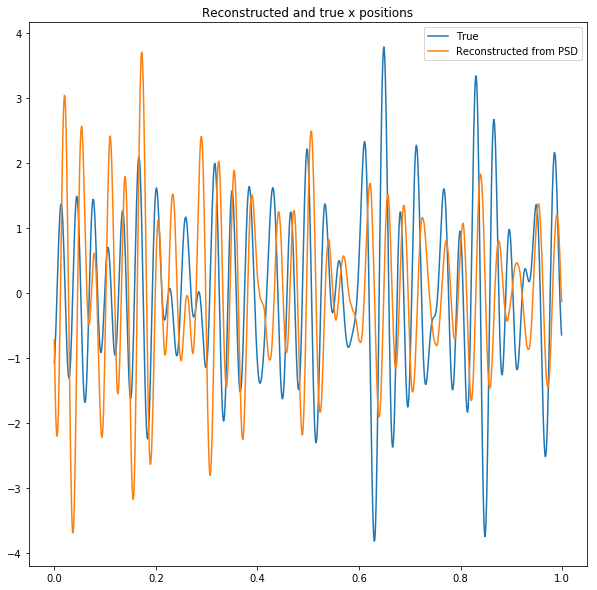

In [10]:
plt.figure(figsize=(10,10))
plt.plot(times, dx, label='True')
plt.plot(times, recon_dx, label='Reconstructed from PSD')
plt.legend()
plt.title("Reconstructed and true x positions")

Text(0.5,1,'Reconstructed and true y positions')

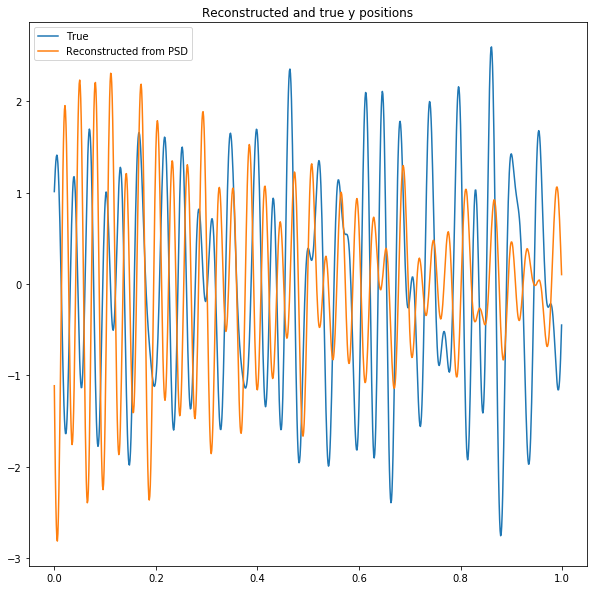

In [11]:
plt.figure(figsize=(10,10))
plt.plot(times, dy, label='True')
plt.plot(times, recon_dy, label='Reconstructed from PSD')
plt.legend()
plt.title("Reconstructed and true y positions")

In [12]:
print(np.std(dx), np.std(dx - recon_dx))

1.2839926707367708 1.6544670603212446


In [13]:
print(np.std(dy), np.std(dy - recon_dy))

1.1287014520659457 1.606586888665348


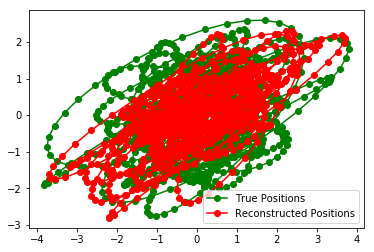